**Part 1** : Investigating OpenCV, pre-processing, and face detection

* [Step 0](#step0): Detect Faces Using a Haar Cascade Classifier
* [Step 1](#step1): Add Eye Detection
* [Step 2](#step2): De-noise an Image for Better Face Detection
* [Step 3](#step3): Blur an Image and Perform Edge Detection
* [Step 4](#step4): Automatically Hide the Identity of an Individual

**Part 2** : Training a Convolutional Neural Network (CNN) to detect facial keypoints

* [Step 5](#step5): Create a CNN to Recognize Facial Keypoints
* [Step 6](#step6): Compile and Train the Model
* [Step 7](#step7): Visualize the Loss

**Part 3** : Putting parts 1 and 2 together to identify facial keypoints on any image!

* [Step 8](#step7): Build a Robust Facial Keypoints Detector (Complete the CV Pipeline)



---
<a id='step0'></a>
## Step 0: Detect Faces Using a Haar Cascade Classifier

Have you ever wondered how high-end cameras automatically find and focus on a certain person's face?  Applications like these depend heavily on the machine learning task known as *face detection* -  which is the task of automatically finding faces in images containing people.  

At its root face detection is a classification problem - that is a problem of distinguishing between distinct classes of things.  With face detection these distinct classes are 1) images of human faces and 2) everything else. 

Will use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  Have downloaded some of these detectors and stored it in the `detectors` directory.


### Import resources

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import math
import cv2                     
import time 

In [20]:
# Load in color image for face detection

def load_image(path, plot = False):
    image = cv2.imread(path)

    # Convert the image to RGB colorspace
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    if plot:
        # Plot our image using subplots to specify a size and title
        fig = plt.figure(figsize = (8,8))
        ax1 = fig.add_subplot(111)
        ax1.set_xticks([])
        ax1.set_yticks([])

        ax1.set_title('Original Image')
        ax1.imshow(image)
    
    return image

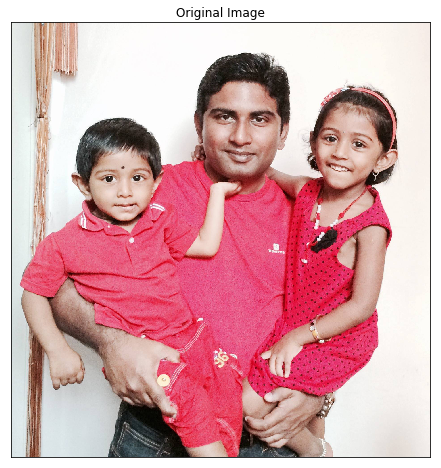

In [36]:
image = load_image('images/image1.jpg',True)

In [29]:
def detect_faces(image, plot=False, scaleFactor=1.1, minNeighbors = 3):
    # Convert the RGB  image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # Extract the pre-trained face detector from an xml file
    face_cascade = cv2.CascadeClassifier('detectors/haarcascade_frontalface_default.xml')

    # Detect the faces in image
    faces = face_cascade.detectMultiScale(gray, scaleFactor, minNeighbors)

    # Make a copy of the orginal image to draw face detections on
    image_with_detections = np.copy(image)

    # Get the bounding box for each detected face
    for (x,y,w,h) in faces:
        # Add a green bounding box to the detections image
        cv2.rectangle(image_with_detections, (x,y), (x+w,y+h), (0,255,0), 3)

    if plot:
        
        # Print the number of faces detected in the image
        print('Number of faces detected:', len(faces))
        # Display the image with the detections
        fig = plt.figure(figsize = (8,8))
        ax1 = fig.add_subplot(111)
        ax1.set_xticks([])
        ax1.set_yticks([])

        ax1.set_title('Image with Face Detections')
        ax1.imshow(image_with_detections)
    
    return image_with_detections

Number of faces detected: 3


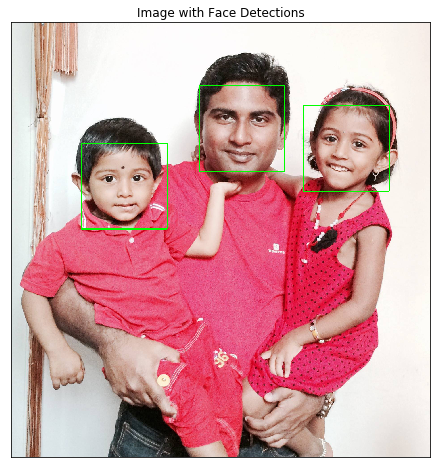

In [40]:
result = detect_faces(image, plot=True,scaleFactor=4,minNeighbors=3)

---
<a id='step1'></a>
## Step 1: Add Eye Detections

There are other pre-trained detectors available that use a Haar Cascade Classifier - including full human body detectors, license plate detectors, and more.  [A full list of the pre-trained architectures can be found here](https://github.com/opencv/opencv/tree/master/data/haarcascades). 

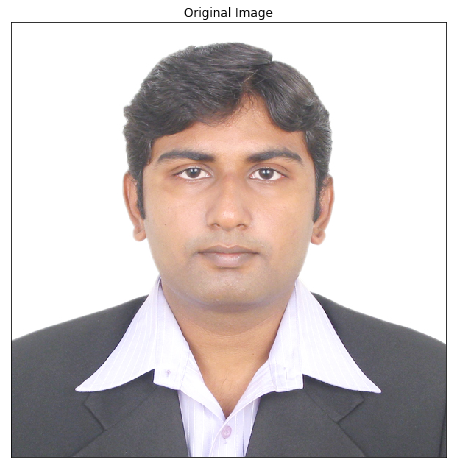

In [48]:
# Load in color image for face detection
photo = load_image('./images/photo.jpg',True)

Number of faces detected: 1


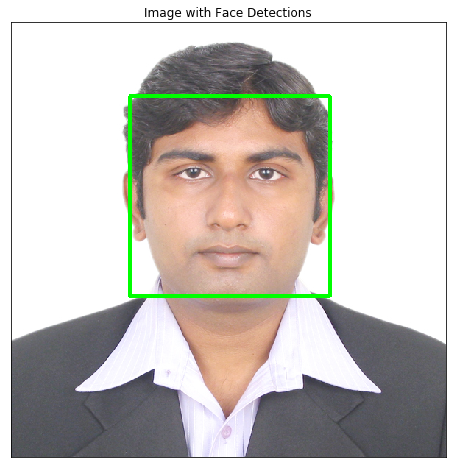

In [49]:
result = detect_faces(photo, True)

### Add an eye detector to the current face detection setup.  

To set up an eye detector, I'll use the stored parameters of the eye cascade detector, called ```haarcascade_eye.xml```.

In [61]:
def detect_faces_and_eyes(image, plot=False):
    # Make a copy of the original image to plot rectangle detections
    gray = np.copy(image)  
    # Convert the RGB  image to grayscale
    gray = cv2.cvtColor(gray, cv2.COLOR_RGB2GRAY)
    
    # detect faces
    image_with_detections =detect_faces(image)
    ## Add eye detection, using haarcascade_eye.xml, to the current face detector algorithm

    # Extract the pre-trained eye detector from an xml file
    eye_cascade = cv2.CascadeClassifier('detectors/haarcascade_eye.xml')

    # Detect the faces in image
    eyes = eye_cascade.detectMultiScale(gray, 1.25, 5)

    ## Loop over the eye detections and draw their corresponding boxes in green on image_with_detections
    for (x,y,w,h) in eyes:
        cv2.rectangle(image_with_detections, (x,y), (x+w,y+h),(255,0,0), 3)  

    if plot:
        # Print the number of faces detected in the image
        print('Number of eyes detected:', len(eyes))
        # Plot the image with both faces and eyes detected
        fig = plt.figure(figsize = (6,6))
        ax1 = fig.add_subplot(111)
        ax1.set_xticks([])
        ax1.set_yticks([])

        ax1.set_title('Image with Face and Eye Detection')
        ax1.imshow(image_with_detections)
        
    return image_with_detections

Number of eyes detected: 2


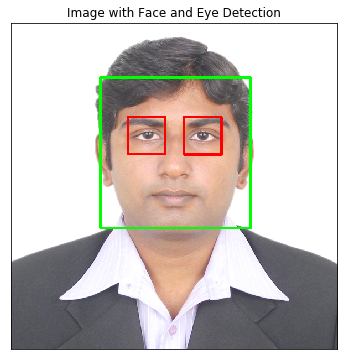

In [62]:
result = detect_faces_and_eyes(photo, True)

---
<a id='step2'></a>
## Step 2: De-noise an Image for Better Face Detection

Image quality is an important aspect of any computer vision task. Typically, when creating a set of images to train a deep learning network, significant care is taken to ensure that training images are free of visual noise or artifacts that hinder object detection.  While computer vision algorithms - like a face detector - are typically trained on 'nice' data such as this, new test data doesn't always look so nice!

When applying a trained computer vision algorithm to a new piece of test data one often cleans it up first before feeding it in.  This sort of cleaning - referred to as *pre-processing* - can include a number of cleaning phases like blurring, de-noising, color transformations, etc., and many of these tasks can be accomplished using OpenCV.

In this subsection I'll explore OpenCV's noise-removal functionality to see how well it can clean up a noisy image, which can then be fed into our trained face detector.

### Create a noisy image to work with

In the next cell, I'll create an artificial noisy version of the previous multi-face image.  This is a little exaggerated - we don't typically get images that are this noisy - but [image noise](https://digital-photography-school.com/how-to-avoid-and-reduce-noise-in-your-images/), or 'grainy-ness' in a digitial image - is a fairly common phenomenon.

In [64]:
def create_noisy_image(image, plot=False):

    # Make an array copy of this image
    image_with_noise = np.asarray(image)

    # Create noise - here we add noise sampled randomly from a Gaussian distribution: a common model for noise
    noise_level = 40
    noise = np.random.randn(image.shape[0],image.shape[1],image.shape[2])*noise_level

    # Add this noise to the array image copy
    image_with_noise = image_with_noise + noise

    # Convert back to uint8 format
    image_with_noise = np.asarray([np.uint8(np.clip(i,0,255)) for i in image_with_noise])

    if plot:
        # Plot our noisy image!
        fig = plt.figure(figsize = (8,8))
        ax1 = fig.add_subplot(111)
        ax1.set_xticks([])
        ax1.set_yticks([])

        ax1.set_title('Noisy Image')
        ax1.imshow(image_with_noise)
    
    return image_with_noise

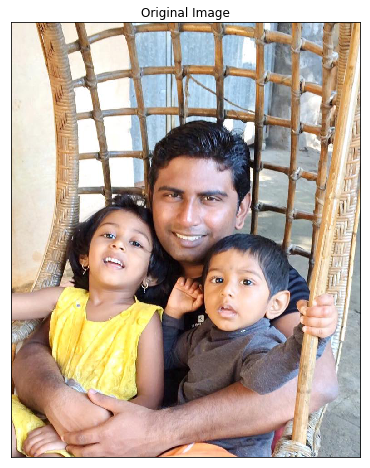

In [65]:
image = image = load_image('images/image2.jpg',True)

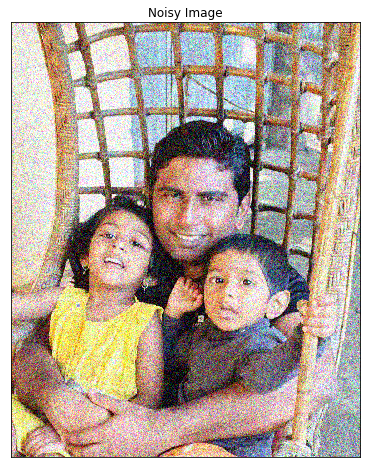

In [66]:
noisy_image = create_noisy_image(image, True)

In the context of face detection, the problem with an image like this is that  - due to noise - we may miss some faces or get false detections.  

In the next cell we apply the same trained OpenCV detector with the same settings as before, to see what sort of detections we get.

Number of faces detected: 3


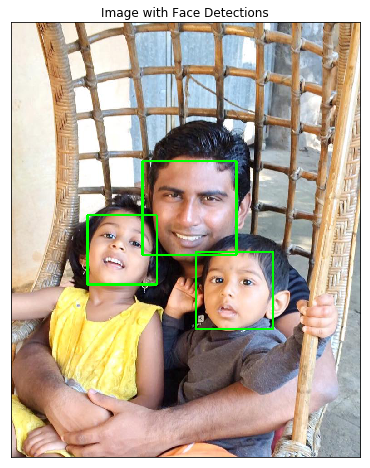

In [75]:
result = detect_faces(image, plot=True,scaleFactor=1.2,minNeighbors=3)

Number of faces detected: 3


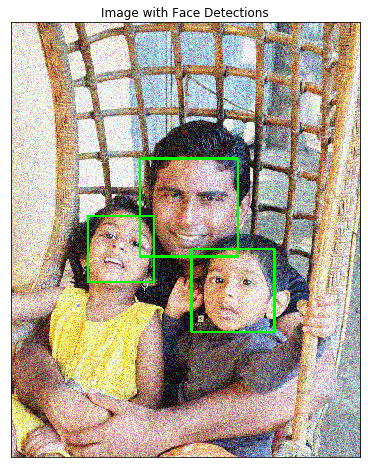

In [72]:
result = detect_faces(noisy_image, plot=True,scaleFactor=1.25,minNeighbors=3)

Even though all faces are detected, for the purpose of exercise, let de-noise the image

### De-noise this image for better face detection

Time to get our hands dirty: using OpenCV's built in color image de-noising functionality called ```fastNlMeansDenoisingColored``` - I'll now de-noise this image enough so that all the faces in the image are properly detected.  Once the image has been cleaned in the next cell, I'll use the cell that follows to run our trained face detector over the cleaned image to check out its detections.

You can find its [official documentation here]([documentation for denoising](http://docs.opencv.org/trunk/d1/d79/group__photo__denoise.html#ga21abc1c8b0e15f78cd3eff672cb6c476) and [a useful example here](http://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_photo/py_non_local_means/py_non_local_means.html).

In [74]:
def denoise_image(image, plot= False):
    # Use OpenCV's built in color image de-noising function to clean up our noisy image!
    denoised_image = cv2.fastNlMeansDenoisingColored(image_with_noise,None,10,10,7,21)
    
    if plot:
        # Display the image with denoise applied
        fig = plt.figure(figsize = (8,8))
        ax1 = fig.add_subplot(111)
        ax1.set_xticks([])
        ax1.set_yticks([])

        ax1.set_title('DeNoised Image')
        ax1.imshow(denoised_image)
    return denoised_image

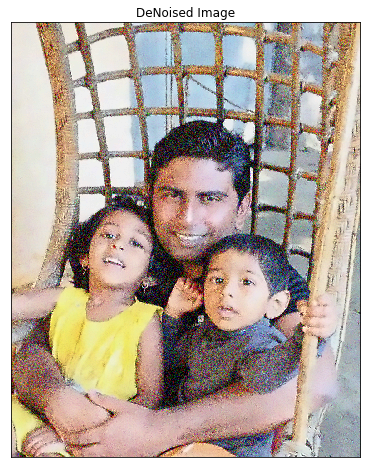

In [77]:
denoised_image = denoise_image(noisy_image, True)

Number of faces detected: 3


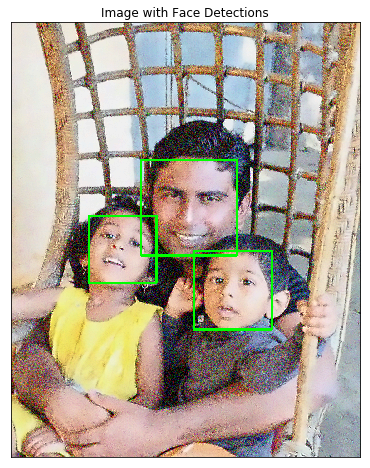

In [78]:
# Run face detection on de-noised image
result = detect_faces(denoised_image, plot=True,scaleFactor=1.25,minNeighbors=3)

---
<a id='step3'></a>

## Step 3: Blur an Image and Perform Edge Detection

Now that we have developed a simple pipeline for detecting faces using OpenCV - let's start playing around with a few fun things we can do with all those detected faces!

### Importance of Blur in Edge Detection

Edge detection is a concept that pops up almost everywhere in computer vision applications, as edge-based features (as well as features built on top of edges) are often some of the best features for e.g., object detection and recognition problems.

Edge detection is a dimension reduction technique - by keeping only the edges of an image we get to throw away a lot of non-discriminating information.  And typically the most useful kind of edge-detection is one that preserves only the important, global structures (ignoring local structures that aren't very discriminative).  So removing local structures / retaining global structures is a crucial pre-processing step to performing edge detection in an image, and blurring can do just that.  

Below is an animated gif showing the result of an edge-detected cat [taken from Wikipedia](https://en.wikipedia.org/wiki/Gaussian_blur#Common_uses), where the image is gradually blurred more and more prior to edge detection.  When the animation begins you can't quite make out what it's a picture of, but as the animation evolves and local structures are removed via blurring the cat becomes visible in the edge-detected image.

<img src="images/Edge_Image.gif" width=400 height=300/>

Edge detection is a **convolution** performed on the image itself, and you can read about Canny edge detection on [this OpenCV documentation page](http://docs.opencv.org/2.4/doc/tutorials/imgproc/imgtrans/canny_detector/canny_detector.html).

### Canny edge detection

In the cell below I load in a test image, then apply *Canny edge detection* on it.  The original image is shown on the left panel of the figure, while the edge-detected version of the image is shown on the right.  Notice how the result looks very busy - there are too many little details preserved in the image before it is sent to the edge detector.  When applied in computer vision applications, edge detection should preserve *global* structure; doing away with local structures that don't help describe what objects are in the image.

In [84]:
def detect_edges(image):

    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)  

    # Perform Canny edge detection
    edges = cv2.Canny(gray,100,200)

    # Dilate the image to amplify edges
    edges = cv2.dilate(edges, None)
    
    # Plot the RGB and edge-detected image
    fig = plt.figure(figsize = (15,15))
    ax1 = fig.add_subplot(121)
    ax1.set_xticks([])
    ax1.set_yticks([])

    ax1.set_title('Original Image')
    ax1.imshow(image)

    ax2 = fig.add_subplot(122)
    ax2.set_xticks([])
    ax2.set_yticks([])

    ax2.set_title('Canny Edges')
    ax2.imshow(edges, cmap='gray')

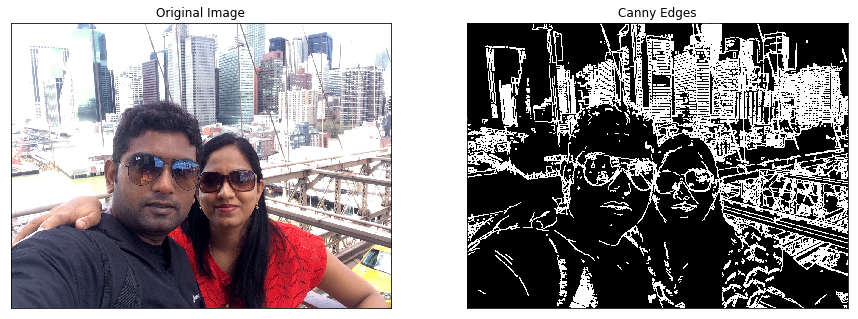

In [87]:
#Load image
image = load_image('images/image3.jpg')
#Detect edges
detect_edges(image)

Without first blurring the image, and removing small, local structures, a lot of irrelevant edge content gets picked up and amplified by the detector.

### Blur the image *then* perform edge detection

In the next cell, I'll repeat this experiment - blurring the image first to remove these local structures, so that only the important boudnary details remain in the edge-detected image.

I'll blur the image by using OpenCV's ```filter2d``` functionality - which is discussed in [this documentation page](http://docs.opencv.org/3.1.0/d4/d13/tutorial_py_filtering.html)

In [89]:
def blur_image(image):
    orig_img = np.copy(image)
    kernel = np.ones((4,4),np.float32)/16
    blur = cv2.filter2D(orig_img,-1,kernel)
    return blur

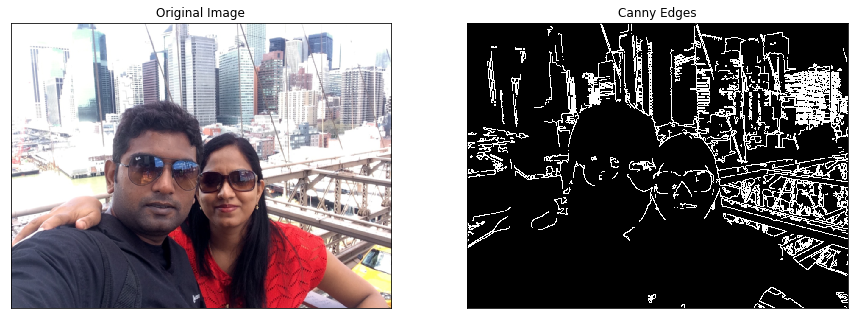

In [90]:
# Perform Canny edge detection on blurred image
detect_edges(blur_image(image))

---
<a id='step4'></a>

## Step 4: Automatically Hide the Identity of an Individual

If you film something like a documentary or reality TV, you must get permission from every individual shown on film before you can show their face, otherwise you need to blur it out - by blurring the face a lot (so much so that even the global structures are obscured)!  This is also true for projects like [Google's StreetView maps](https://www.google.com/streetview/) - an enormous collection of mapping images taken from a fleet of Google vehicles.  Because it would be impossible for Google to get the permission of every single person accidentally captured in one of these images they blur out everyone's faces, the detected images must automatically blur the identity of detected people.  Here's a few examples of folks caught in the camera of a Google street view vehicle.

<img src="images/google_street_view_1.jpg" width=400 height=300/>
<img src="images/google_street_view_2.jpg" width=400 height=300/>


### Read in an image to perform identity detection

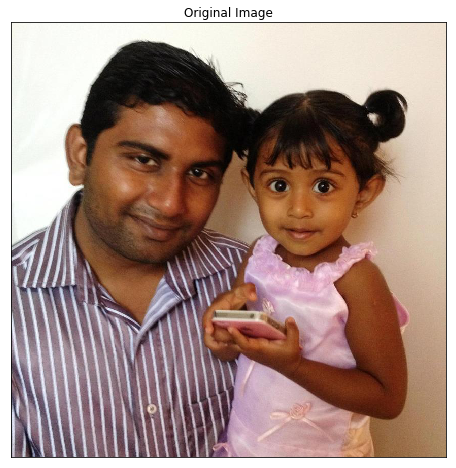

In [92]:
image = load_image('images/image4.jpg',True)

Number of faces detected: 2


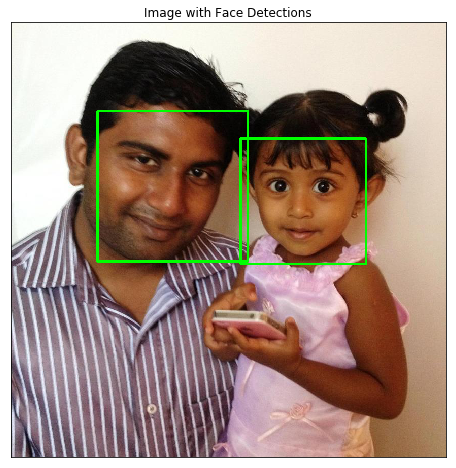

In [93]:
# Run face detection on the image
result = detect_faces(image, plot=True,scaleFactor=1.25,minNeighbors=3)

In [104]:
# Tweeking the earlier funciton to blur the faces instead of just drawing a box around it

def blur_faces(image, plot=False, scaleFactor=1.1, minNeighbors = 3):
    # Convert the RGB  image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # Extract the pre-trained face detector from an xml file
    face_cascade = cv2.CascadeClassifier('detectors/haarcascade_frontalface_default.xml')

    # Detect the faces in image
    faces = face_cascade.detectMultiScale(gray, scaleFactor, minNeighbors)

    # Make a copy of the orginal image to draw face detections on
    image_with_detections = np.copy(image)

    # Get the bounding box for each detected face
    for (x,y,w,h) in faces:
        # get the rectangle img around all the faces
        cv2.rectangle(image_with_detections, (x,y), (x+w,y+h), (255,255,0), 3)
        sub_face = image_with_detections[y:y+h, x:x+w]
        # apply a gaussian blur on this new recangle image
        sub_face = cv2.GaussianBlur(sub_face,(23, 23), 30)
        # merge this blurry rectangle to our final image
        image_with_detections[y:y+sub_face.shape[0], x:x+sub_face.shape[1]] = sub_face

    if plot:
        
        # Print the number of faces detected in the image
        print('Number of faces detected:', len(faces))
        # Display the image with the detections
        fig = plt.figure(figsize = (8,8))
        ax1 = fig.add_subplot(111)
        ax1.set_xticks([])
        ax1.set_yticks([])

        ax1.set_title('Bured Image after Face Detections')
        ax1.imshow(image_with_detections)
    
    return image_with_detections

Number of faces detected: 2


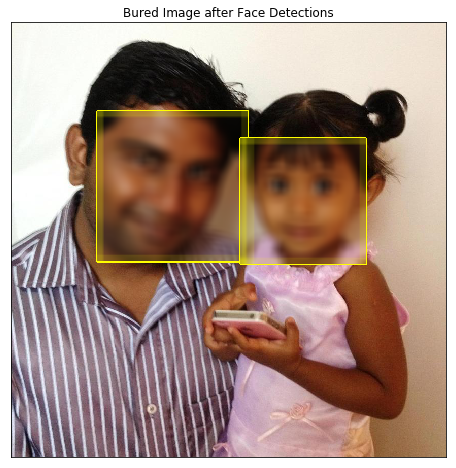

In [105]:
# Run face detection and blur on the detected faces in the image
result = blur_faces(image, plot=True,scaleFactor=1.25,minNeighbors=3)

---
<a id='step5'></a>

## Step 5: Create a CNN to Recognize Facial Keypoints

OpenCV is often used in practice with other machine learning and deep learning libraries to produce interesting results.  In this stage of the project I will create my own end-to-end pipeline - employing convolutional networks in keras along with OpenCV - to apply a "selfie" filter to streaming video and images.  

I will start by creating and then training a convolutional network that can detect facial keypoints in a small dataset of cropped images of human faces.  What are facial keypoints?  Let's take a look at some examples.

<img src="images/keypoints_test_results.png" width=400 height=300/>

Facial keypoints (also called facial landmarks) are the small blue-green dots shown on each of the faces in the image above - there are 15 keypoints marked in each image.  They mark important areas of the face - the eyes, corners of the mouth, the nose, etc.  Facial keypoints can be used in a variety of machine learning applications from face and emotion recognition to commercial applications like the image filters popularized by Snapchat.

In [106]:
from keras.models import load_model
from pandas.io.parsers import read_csv
from sklearn.utils import shuffle

Using TensorFlow backend.


In [107]:
import os
train = 'data/training.csv'
test = 'data/test.csv'

### Make a facial keypoint detector

But first things first: how can we make a facial keypoint detector?  Well, at a high level, notice that facial keypoint detection is a *regression problem*.  A single face corresponds to a set of 15 facial keypoints (a set of 15 corresponding $(x, y)$ coordinates, i.e., an output point).  Because our input data are images, we can employ a *convolutional neural network* to recognize patterns in our images and learn how to identify these keypoint given sets of labeled data.

In order to train a regressor, we need a training set - a set of facial image / facial keypoint pairs to train on.  For this I'll be using [this dataset from Kaggle](https://www.kaggle.com/c/facial-keypoints-detection/data). You'll need to download this data and place it in the `data` directory. The training dataset contains several thousand $96 \times 96$ grayscale images of cropped human faces, along with each face's 15 corresponding facial keypoints that have been placed by hand, and recorded in $(x, y)$ coordinates.  This wonderful resource also has a substantial testing set.

In [113]:
def load_data(path):

    df = read_csv(os.path.expanduser(path))  # load dataframes

    # The Image column has pixel values separated by space 
    # Need to convert the values to numpy arrays
    df['Image'] = df['Image'].apply(lambda im: np.fromstring(im, sep=' '))
    df = df.dropna()  # drop all rows that have missing values in them

    X = np.vstack(df['Image'].values) / 255.  # scale pixel values to [0, 1]
    X = X.astype(np.float32)
    X = X.reshape(-1, 96, 96, 1) # return each images as 96 x 96 x 1

    y = df[df.columns[:-1]].values
    y = (y - 48) / 48  # scale target coordinates to [-1, 1]
    y = y.astype(np.float32)
   
    # shuffle  data set
    X, y = shuffle(X, y, random_state=42)  
   
    return X, y

In [111]:
X_train, y_train = load_data(train)

In [112]:
x_test, y_test = load_data(test)

In [114]:
X_train.shape

(2140, 96, 96, 1)

In [117]:
y_train.shape

(2140, 30)

In [118]:
x_test.shape

(1783, 96, 96, 1)

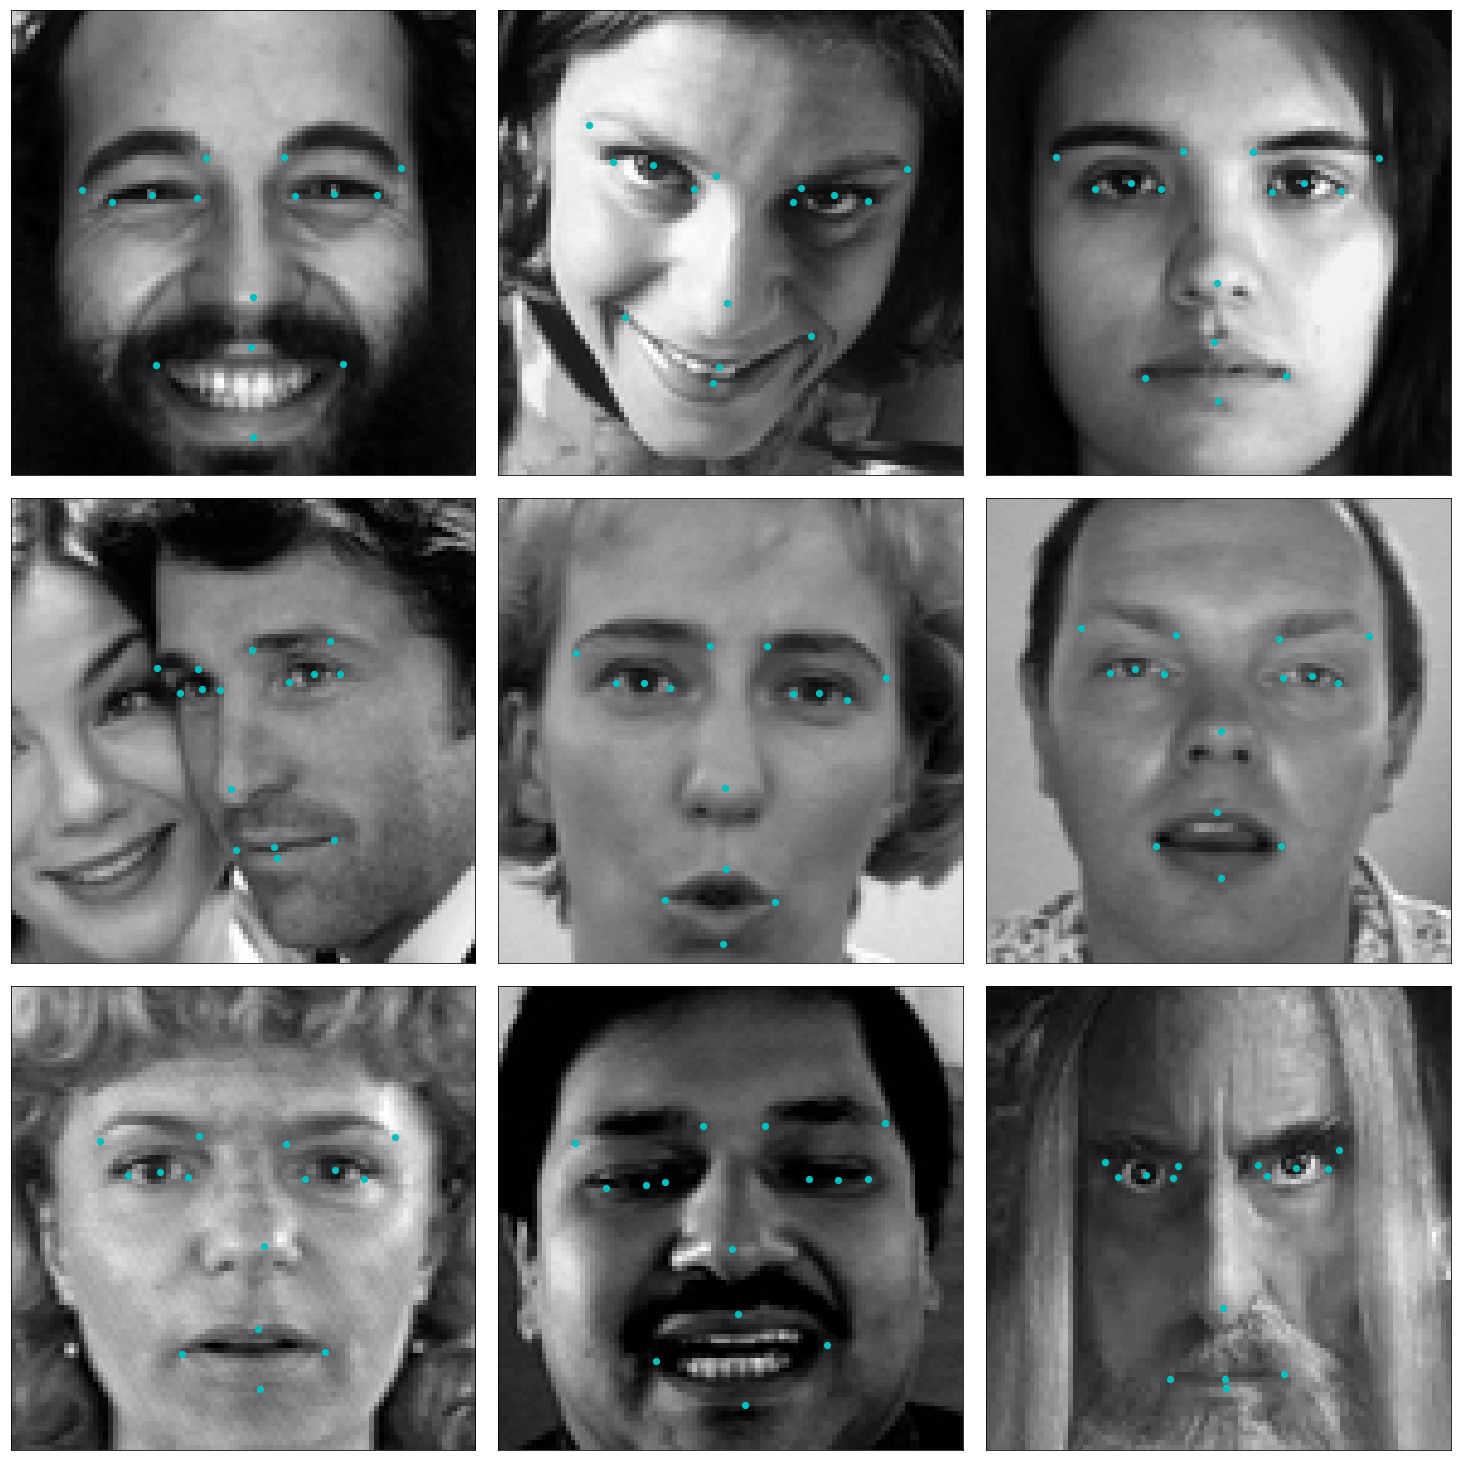

In [122]:
#Plot some sample images

import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(20,20))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
for i in range(9):
    axis = fig.add_subplot(3, 3, i + 1, xticks=[], yticks=[])
    img = X_train[i]
    marks = y_train[i]
    axis.imshow(np.squeeze(img), cmap='gray') # plot the image
    marks = marks * 48 + 48 # undo the normalization
    # Plot the keypoints
    axis.scatter(marks[0::2], marks[1::2], marker='o', c='c', s=40)

For each training image, there are two landmarks per eyebrow (**four** total), three per eye (**six** total), **four** for the mouth, and **one** for the tip of the nose.

In [127]:
# Import deep learning resources from Keras
from keras.models import Sequential
from keras.layers import Dropout
from keras.layers import Flatten, Dense
from keras.layers.convolutional import Convolution2D

# Build a CNN architecture

model = Sequential()

model.add(Convolution2D(16,3,3, subsample=(2,2) ,activation='relu', input_shape=(96, 96, 1)))
model.add(Convolution2D(32,3,3, subsample=(2,2) ,activation='relu'))
model.add(Convolution2D(64,3,3, subsample=(2,2) ,activation='relu'))
model.add(Convolution2D(128,3,3, subsample=(2,2) ,activation='relu'))

model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(30))

# Summarize the model
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_1 (Convolution2D)  (None, 47, 47, 16)    160         convolution2d_input_1[0][0]      
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 23, 23, 32)    4640        convolution2d_1[0][0]            
____________________________________________________________________________________________________
convolution2d_3 (Convolution2D)  (None, 11, 11, 64)    18496       convolution2d_2[0][0]            
____________________________________________________________________________________________________
convolution2d_4 (Convolution2D)  (None, 5, 5, 128)     73856       convolution2d_3[0][0]            
___________________________________________________________________________________________

In [141]:
from keras.callbacks import ModelCheckpoint, History
from keras.optimizers import Adam

hist = History()
checkpoint = ModelCheckpoint('model_{epoch:02d}.h5')
epochs = 20

## Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

model.fit(X_train,y_train, validation_split=0.2, nb_epoch=epochs, shuffle=True, verbose=1,
          callbacks=[checkpoint, hist])

model.save('model_final.h5')

Train on 1712 samples, validate on 428 samples
Epoch 1/20
1712/1712 [==============================] - 0s - loss: 0.0020 - acc: 0.7652 - val_loss: 0.0013 - val_acc: 0.7734
Epoch 2/20
1712/1712 [==============================] - 0s - loss: 0.0014 - acc: 0.7675 - val_loss: 0.0014 - val_acc: 0.7921
Epoch 3/20
1712/1712 [==============================] - 0s - loss: 0.0013 - acc: 0.7810 - val_loss: 0.0014 - val_acc: 0.7664
Epoch 4/20
1712/1712 [==============================] - 0s - loss: 0.0012 - acc: 0.7891 - val_loss: 0.0013 - val_acc: 0.7710
Epoch 5/20
1712/1712 [==============================] - 0s - loss: 0.0013 - acc: 0.8020 - val_loss: 0.0017 - val_acc: 0.7874
Epoch 6/20
1712/1712 [==============================] - 0s - loss: 0.0013 - acc: 0.7921 - val_loss: 0.0013 - val_acc: 0.7874
Epoch 7/20
1712/1712 [==============================] - 0s - loss: 0.0011 - acc: 0.8014 - val_loss: 0.0013 - val_acc: 0.7710
Epoch 8/20
1712/1712 [==============================] - 0s - loss: 0.0011 - ac

---
<a id='step7'></a>

## Step 7: Visualize the Loss and Test Predictions

__Question 1:__ Outline the steps you took to get to your final neural network architecture and your reasoning at each step.

__Answer:__

I have used the variation of leNet and the Nvidia architectrue for my other projecs, one such was for behaviour cloning. The below architecure is inspired from the Nvidia architecutre to use muti layers of convolutin followed by flattening and using a fully connected layer, the layers are just a power of 2 and finally a dropout layer to ensure that it prevents overfitting and generalize better.

Layer (type)                                          
==================
convolution2d_1 (Convolution2D)  16
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  32            
____________________________________________________________________________________________________
convolution2d_3 (Convolution2D)  64        
____________________________________________________________________________________________________
convolution2d_4 (Convolution2D)  128       
____________________________________________________________________________________________________
flatten_1 (Flatten)              0                      
____________________________________________________________________________________________________
dense_1 (Dense)                  512
____________________________________________________________________________________________________
dropout_1 (Dropout)              0.2                    
____________________________________________________________________________________________________
dense_2 (Dense)                  30
____________________________________________________________________________________________________


__Question 2:__ Defend your choice of optimizer.  Which optimizers did you test, and how did you determine which worked best?

__Answer:__ 


While there are options to pick an optimizer as listed below from the listed resource, I ended up using the adam optimizer which I have used in other projects and provided good results.

![image](http://i.imgur.com/s25RsOr.gif "Resource")


Use the code cell below to plot the training and validation loss of your neural network.  You may find [this resource](http://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/) useful.

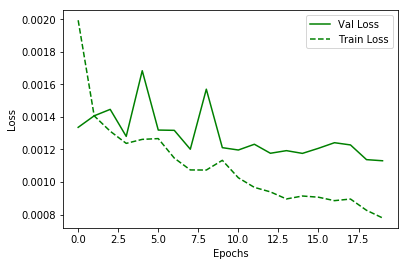

In [142]:
# Visualize the training and validation loss of the neural network
plt.plot(range(epochs), hist.history[
         'val_loss'], 'g-', label='Val Loss')
plt.plot(range(epochs), hist.history[
         'loss'], 'g--', label='Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

__Question 3:__  Do you notice any evidence of overfitting or underfitting in the above plot?  If so, what steps have you taken to improve your model?  Note that slight overfitting or underfitting will not hurt your chances of a successful submission, as long as you have attempted some solutions towards improving your model (such as _regularization, dropout, increased/decreased number of layers, etc_).

__Answer:__

I do see some slight overfitting around the 10th epoch for the testing set, and there is a constant ups and downs in the validation error. A different optimizer would probably help mothen that out. But I was happy with the validation accuracy and have not made any changes to it. I applied a dropout layer right after the Dense layer with 512 nodes before the output layer to try and prevent some overfitting. 

Overall its still hard to determine the cause of some erros, such as the first image in the second row in below cell test prediction visualization. It is hard to say if the model has memorised it or if it was the result of generalization. The peculiar thing about the imgae is that the face is probably tilted more than 35 degree resulting in incorrect keypoint predication.

### Visualize a Subset of the Test Predictions

Below we visualize the model's predicted keypoints on a subset of the testing images.

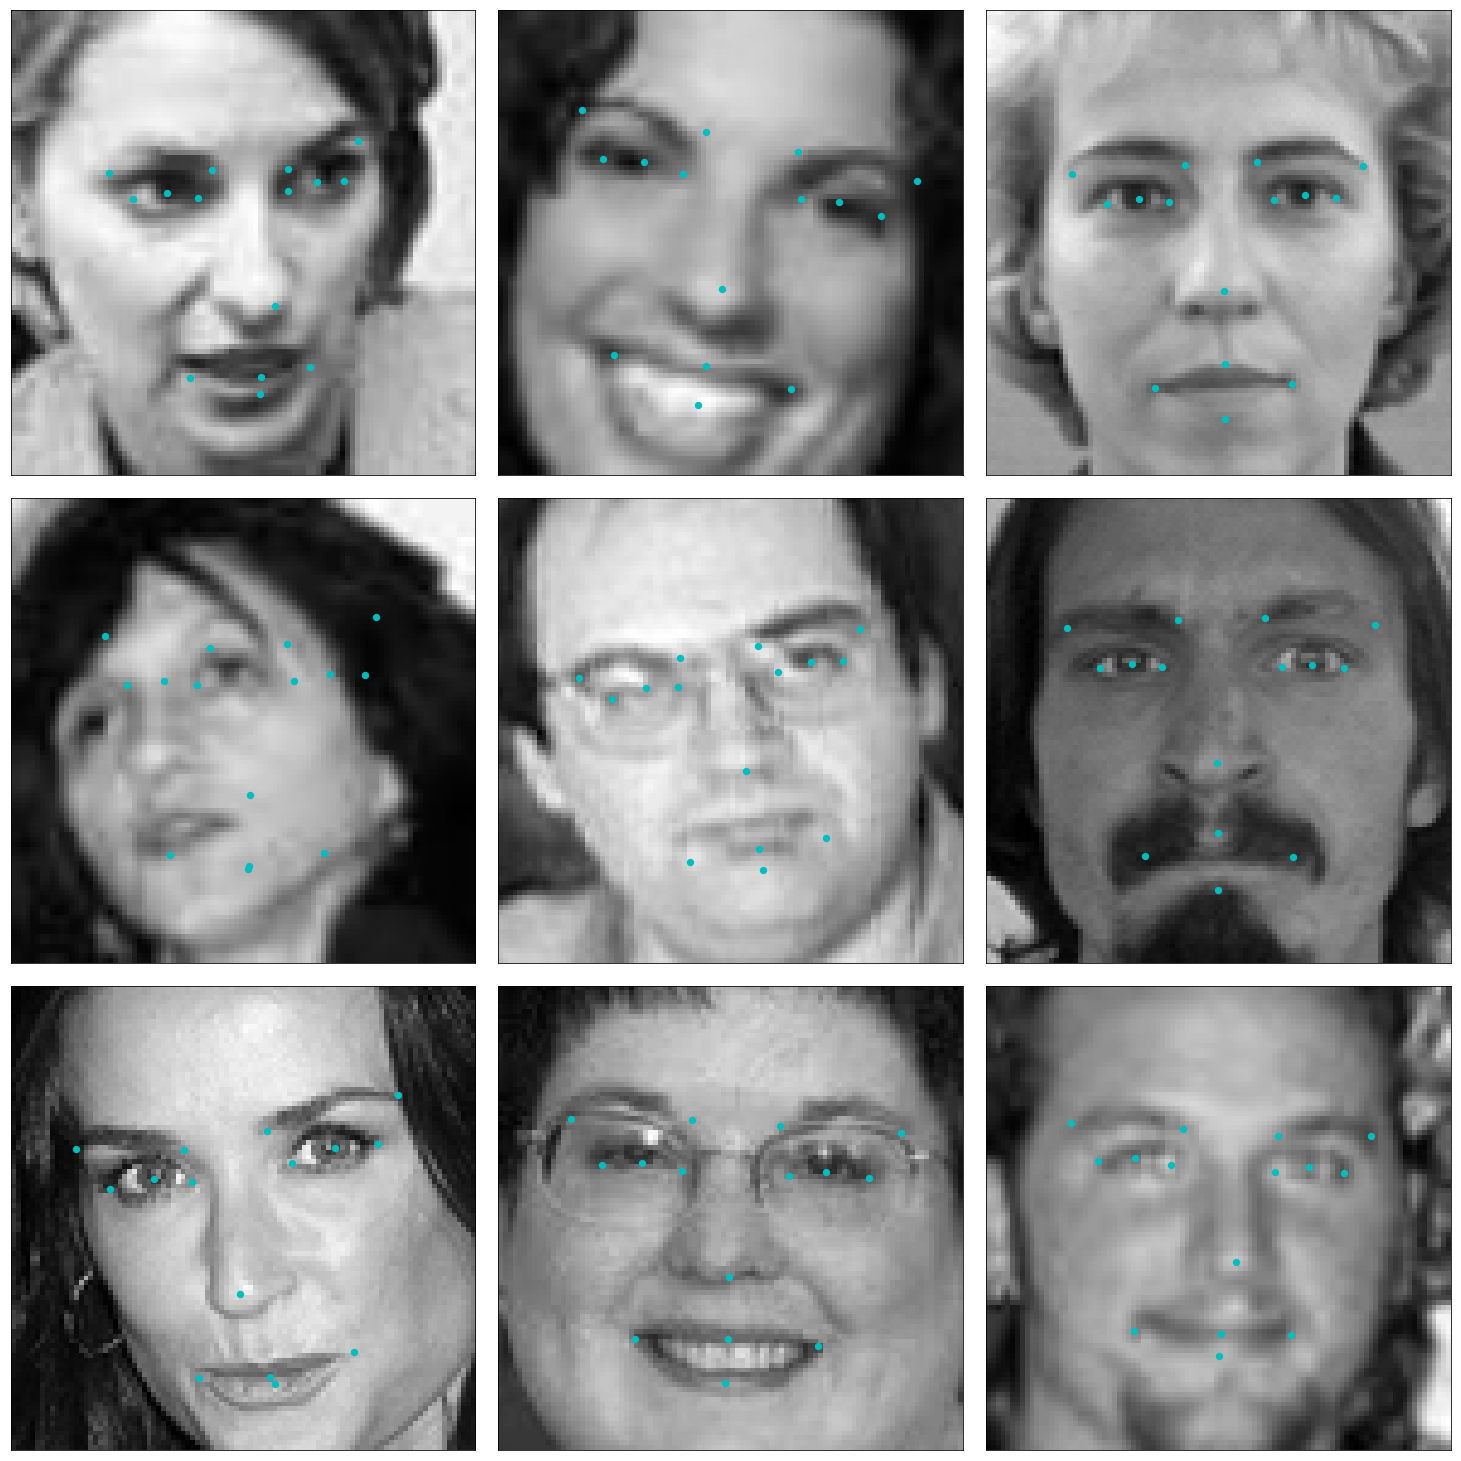

In [143]:
y_test = model.predict(x_test)
fig = plt.figure(figsize=(20,20))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
for i in range(9):
    axis = fig.add_subplot(3, 3, i + 1, xticks=[], yticks=[])
    img = x_test[i]
    marks = y_test[i]
    axis.imshow(np.squeeze(img), cmap='gray') # plot the image
    marks = marks * 48 + 48 # undo the normalization
    # Plot the keypoints
    axis.scatter(marks[0::2], marks[1::2], marker='o', c='c', s=40)

---
<a id='step8'></a>

## Step 8: Complete the pipeline

With the work done in Sections 1 and 2 of this notebook, along with a freshly trained facial keypoint detector, we can now complete the full pipeline.  That is given a color image containing a person or persons we can now 

- Detect the faces in this image automatically
- Predict the facial keypoints in each face detected in the image
- Paint predicted keypoints on each face detected

In this Subsection we will do just this!

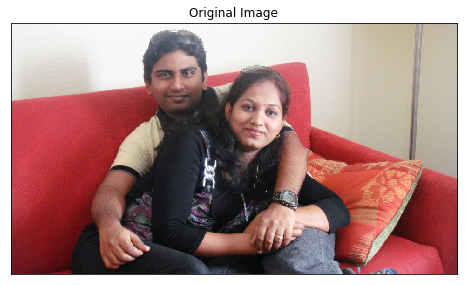

In [146]:
#Load image
image = load_image('images/image5.jpg', True)

Number of faces detected: 2


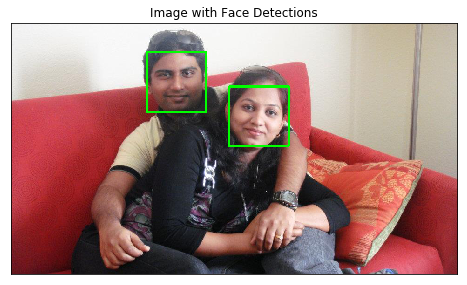

In [147]:
# Run face detection on the image
result = detect_faces(image, plot=True,scaleFactor=1.25,minNeighbors=3)

In [154]:
# Function takes in a image and the model as key inputs and
# returns and image with keypoints on identified faces in the image

def detect_keypoints(image, model, scaleFactor=1.25, minNeighbors = 3):
    # Convert the RGB  image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # Extract the pre-trained face detector from an xml file
    face_cascade = cv2.CascadeClassifier('detectors/haarcascade_frontalface_default.xml')

    # Detect the faces in image
    faces = face_cascade.detectMultiScale(gray, scaleFactor, minNeighbors)

    # Make a copy of the orginal image to draw face detections on
    image_with_detections = np.copy(image)

    fig = plt.figure(figsize=(40, 40))
    ax = fig.add_subplot(121, xticks=[], yticks=[])
    ax.set_title('Image with Facial Keypoints')
    key_size = 3
    
    # Get the bounding box for each detected face
    for (x,y,w,h) in faces:
        # get the rectangle img around all the faces
        cv2.rectangle(image_with_detections, (x,y), (x+w,y+h), (255,255,0), 1)
        sub_face = image_with_detections[y:y+h, x:x+w]

        orig_face_shape = sub_face.shape
        gray_crop = cv2.cvtColor(sub_face, cv2.COLOR_BGR2GRAY)
        resize_gray_crop = cv2.resize(gray_crop, (96, 96)) / 255

        keypoints = np.squeeze(model.predict(np.expand_dims(np.expand_dims(resize_gray_crop, axis=-1), axis=0)))
        ax.scatter(((keypoints[0::2] * 48 + 48)*orig_face_shape[0]/96)+x, 
                   ((keypoints[1::2] * 48 + 48)*orig_face_shape[1]/96)+y, 
                   marker='o', c='c', s=key_size)
        

    ax.imshow(image_with_detections)
    
    return image_with_detections

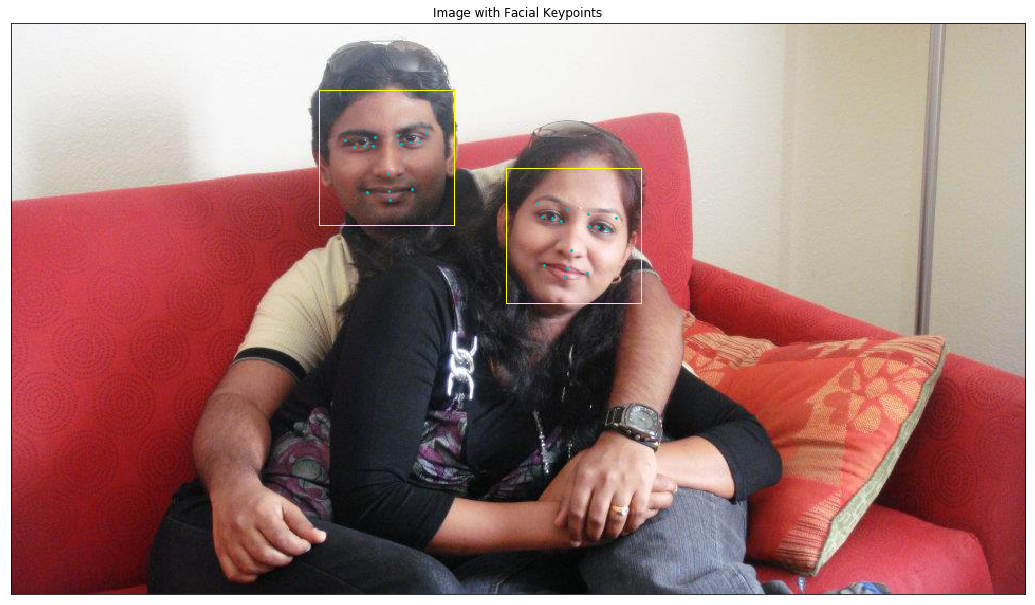

In [156]:
model_path = 'model_final.h5'
model = load_model(model_path)
result = detect_keypoints(image,model)

In [157]:
#Fin